## Grover Boosting
This notebook presents a theoretical and experimental analysis of a "boosting" strategy for Grover's Algorithm.
The primary goal is to determine if performing `k` independent trials of a sub-optimal Grover's circuit (using $t < t^*$ iterations) can achieve a higher overall success probability than a standard, single-run implementation.
This investigation is conducted under the constraint of a fixed computational budget, where the total number of oracle calls is held constant at the optimal value $t^*$, such that $k \cdot t = t^*$.
The following sections contain the mathematical derivation for the boosted success probability, $P[\text{Success}] = 1-\cos^{2k}((2t+1)\theta)$, and the analytical and graphical methods used to find the optimal boosting parameters.
Finally, the notebook outlines an experimental procedure to test the performance of the $t=1$ boosting case, with the aim of measuring its efficacy and verifying that a quantum advantage over classical search is maintained.


## Background 

The standard probability of success given $t$ iterations of the grover operator is $P(t) = \sin^2((2t + 1)\theta)$ where $\theta = \frac{\pi}{4} \sqrt{\frac{N}{M}}$. $N$ is the total number of inputs to the circuit, and $M$ is the number of satisfying inputs, and for our purposes we assume $M = 1$. 

In [24]:
from math import sqrt, floor
import numpy as np

# configuration 
n = 4
N = 2**n
M = 1
theta = sqrt(M/N)
t_opt = floor(np.pi/4 * sqrt(N/M))

def grover_success(t: int) -> float:
    return math.sin((2*t + 1) * theta)**2

print(f'For N = {N} and M = {M} the optimal number of grover iterations is {t_opt} with a {grover_success(t_opt) * 100:.2f}% chance of success')

For N = 16 and M = 1 the optimal number of grover iterations is 3 with a 96.82% chance of success


## Boost

We ask "how many calls to the oracle are needed if we only ever perform a single grover iteration?" 
Mathematically, how many indepdent trials of a single operation are needed to achieve similar rates of success: 
$$ P[\text{Success using } k \text{ trials}] = 1 - (1 - P(t))^k $$

If we let $c = \frac{1 - (1 - P(t))^k}{P(t^*)}$ then $\frac{1}{c}$ is the number of times we must repeat our $k$ trials. 
To determine the cost $E[\text{Cost}]$ of our boost, we need to know the total number of oracle queries.
That would be $k t c$ since for each $k$ we query the oracle $t$ times. 
$$ E[\text{Cost}] = \frac{kt}{1 - (1 - P(t))^k} $$

In this specific experiment, we let $k = t^*$ and $t = 1$. 

$$ E[\text{Cost}] = \lfloor\frac{3}{0.874}\rfloor = 3 $$


In [14]:
c = (1 - (1 - grover_success(1))**t_opt) / grover_success(t_opt)
print(f'Estimated Cost = {t_opt}/{c:.3f} = {t_opt/c:.2f}')

Estimated Cost = 3/0.874 = 3.43


For this small example, it turns out that $k = t^*$ but this is not always the case. 
For $n = 16$ we find $t^* = 201$ and $c \approx 37$ so $E[\text{Cost}] = 7500$ queries. 
This beats the classical brute force $2^n$ queries by a factor of 10!

In [2]:
# Load Qiskit
from qiskit_ibm_runtime import QiskitRuntimeService
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv()
API_TOKEN = os.getenv("API_TOKEN")
API_INSTANCE = os.getenv("API_INSTANCE", None)
#API_INSTANCE = "rpi/research/magdon"
service = QiskitRuntimeService(channel="ibm_quantum", token=API_TOKEN, instance=API_INSTANCE)
backend = service.backend(name="ibm_rensselaer")
#backend = service.least_busy()

/tmp/ipykernel_691400/1809614354.py:10: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel="ibm_quantum", token=API_TOKEN, instance=API_INSTANCE)


## View Single Trial

In [15]:
expr = [[2, -4, 1], [-2, 1, 3], [-2, -4, -3], [2, -3, 1], [-2, -1, 3], [-2, 3, -4], [-3, -2, -4], [-4, -2, -1], [-2, -4, -1], [-3, 2, -1], [-2, 3, 4], [-1, -2, 4], [-1, 4, 3], [4, 1, 2], [2, -3, -4], [-1, 3, 2]]
solution = [-1, 2, 3, -4]

optimal_grover_iterations = t_opt

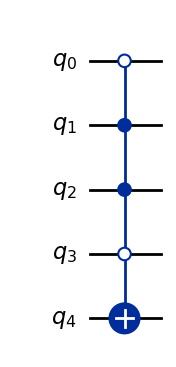

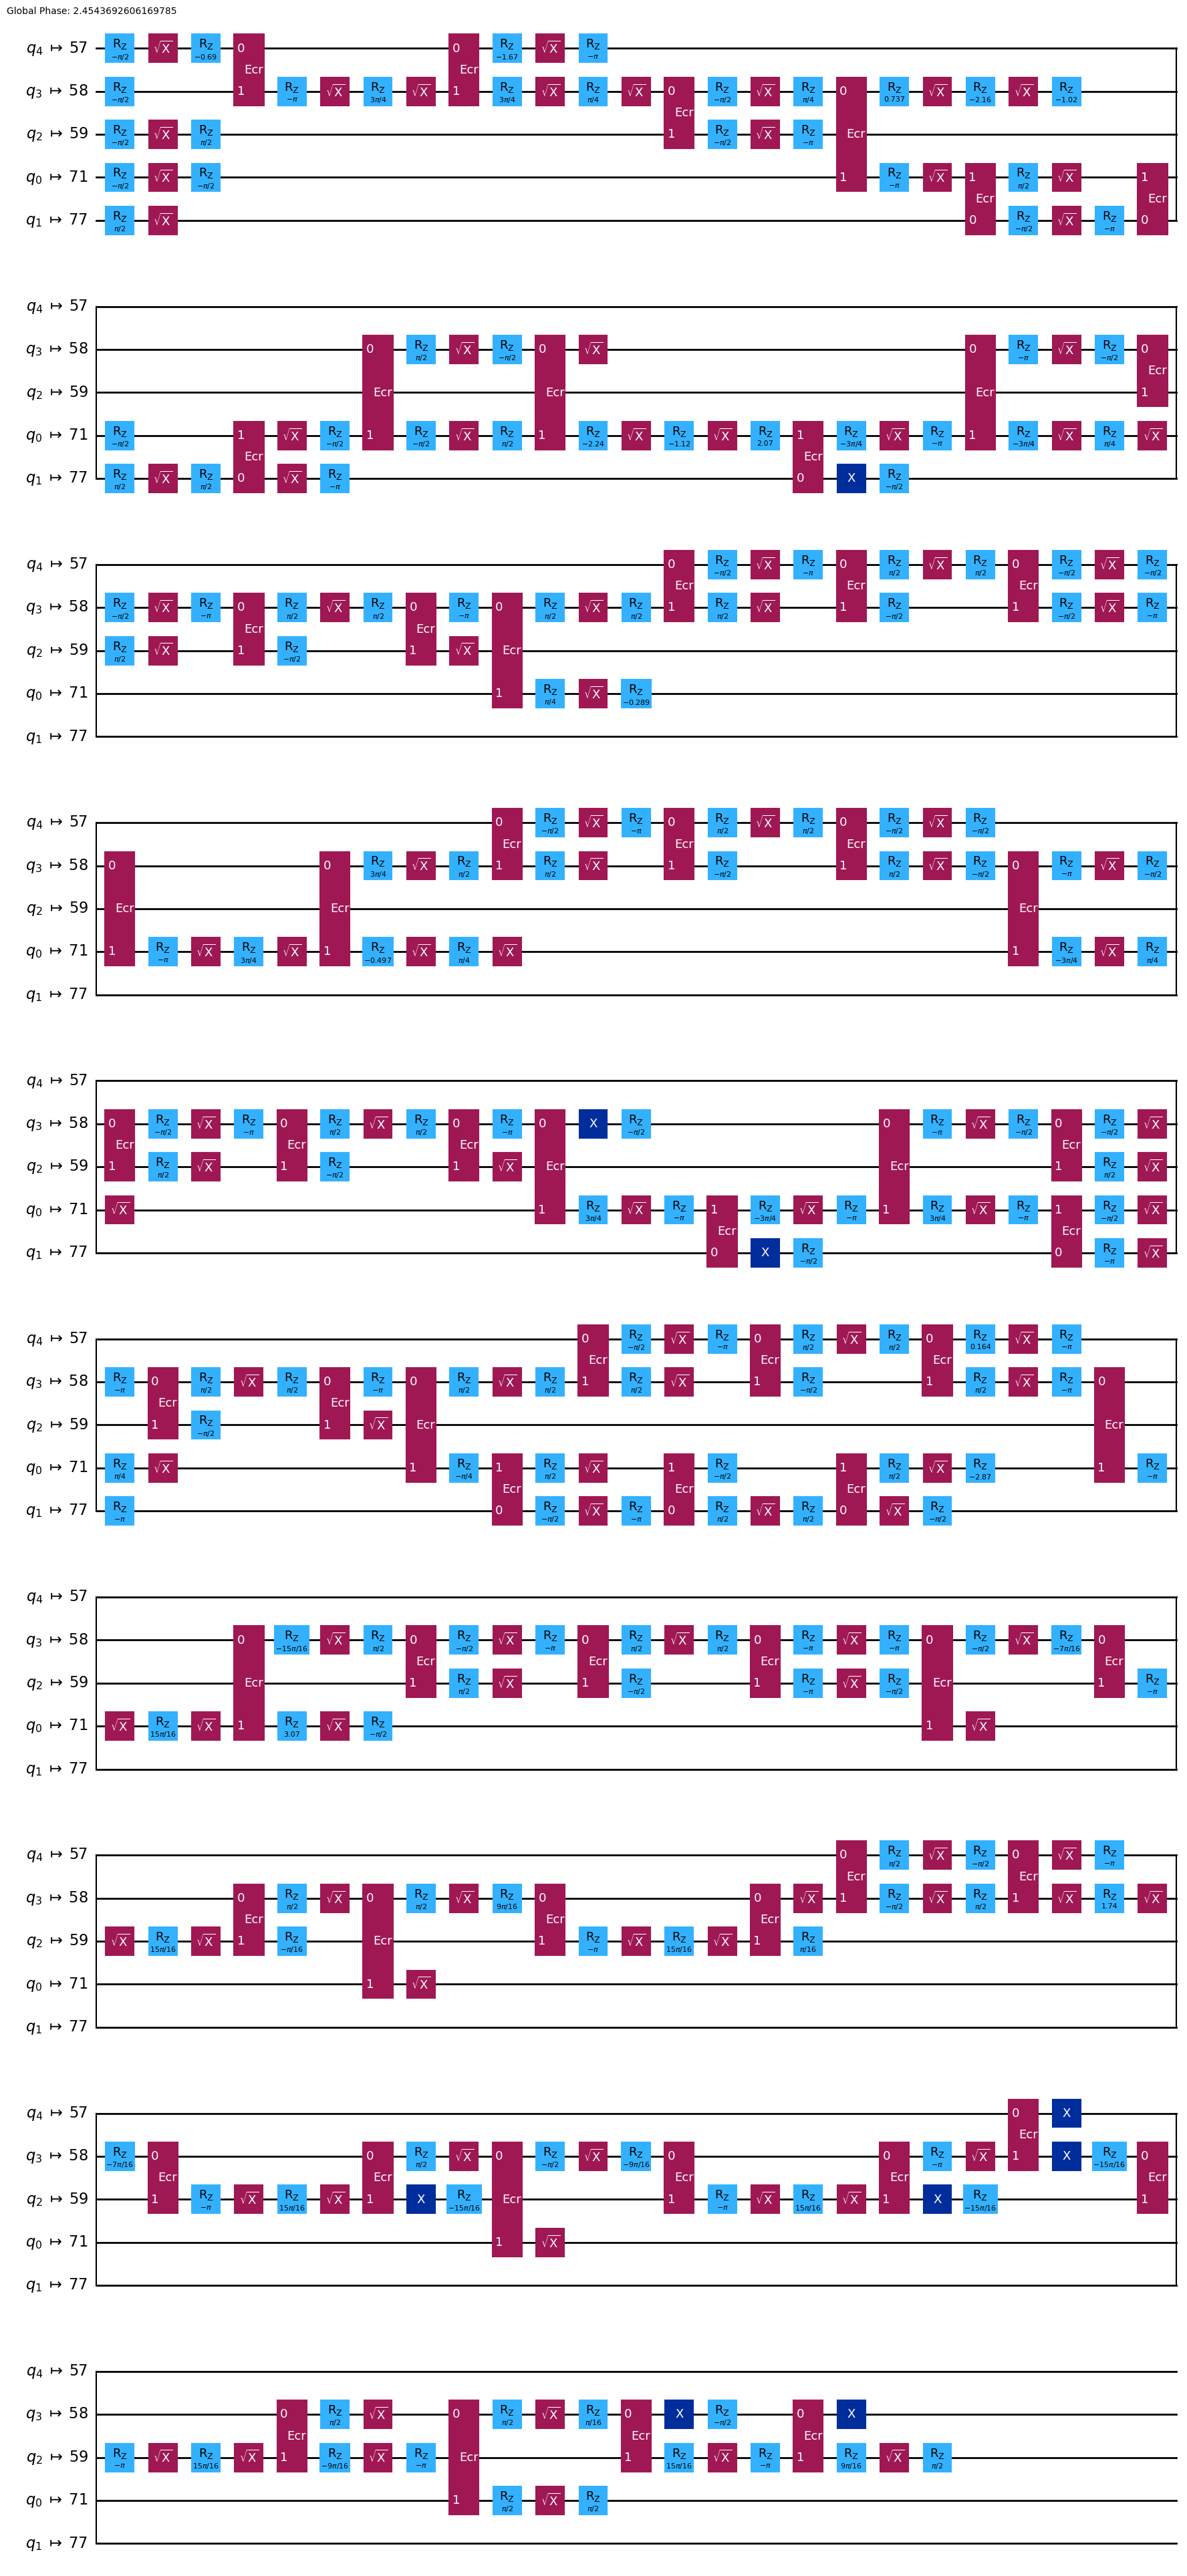

In [20]:
from tweedledum.bool_function_compiler import QuantumCircuitFunction, circuit_input
from tweedledum import BitVec
import qiskit

@circuit_input(vars=lambda n: BitVec(n))
def parameterized_3sat(n: int, circuit) -> BitVec(1):
    """ Determines if the given input satisfies the input circuit"""
    s = BitVec(1, 1)  # Start with True 

    # loop over each clause
    for clause in circuit:
        # construct clause result
        expr = BitVec(1, 0)
        for var in clause:
            if var < 0: # negative -> apply not
                expr = expr | ~vars[abs(var)-1]
            else:
                expr = expr | vars[abs(var)-1]

        # apply clause result to final result
        s = s & expr
    return s


classical = QuantumCircuitFunction(parameterized_3sat, 4, expr)
oracle = classical.truth_table_synthesis()
rpi_qc = qiskit.transpile(oracle, backend=backend, optimization_level=3)

display(oracle.draw('mpl'))
display(rpi_qc.draw('mpl'))

In [37]:
from typing import Any
from collections import Counter

def circuit_stats(qc: QuantumCircuit, verbose: bool = True) -> Dict[str, Any]:
    """
    Print basic statistics for a Qiskit QuantumCircuit.
    
    Args:
        qc: QuantumCircuit to analyze
        verbose: Print results to console
        
    Returns:
        Dictionary with circuit statistics
    """
    # Basic circuit properties
    stats = {
        'num_qubits': qc.num_qubits,
        'num_clbits': qc.num_clbits,
        'depth': qc.depth(),
        'size': qc.size(),  # Total number of gates
        'width': qc.width(),  # Total qubits + classical bits
    }
    
    # Gate composition
    gate_counts = Counter()
    two_qubit_gates = 0
    
    for instruction in qc.data:
        gate_name = instruction.operation.name
        gate_counts[gate_name] += 1
        
        # Count multi-qubit gates (potential noise sources)
        if len(instruction.qubits) >= 2:
            two_qubit_gates += 1
    
    stats['gate_counts'] = dict(gate_counts)
    stats['two_qubit_gates'] = two_qubit_gates
    stats['unique_gates'] = len(gate_counts)
    
    # Circuit complexity metrics
    stats['cx_count'] = gate_counts.get('cx', 0) + gate_counts.get('cnot', 0)
    stats['h_count'] = gate_counts.get('h', 0)
    stats['measurement_count'] = gate_counts.get('measure', 0)
    
    # Potential fidelity issues
    fidelity_concerns = []
    
    if stats['depth'] > 100:
        fidelity_concerns.append(f"High depth ({stats['depth']}) - gate errors accumulate")
    
    if stats['two_qubit_gates'] > 50:
        fidelity_concerns.append(f"Many 2-qubit gates ({stats['two_qubit_gates']}) - higher error rates")
    
    if stats['num_qubits'] > 20:
        fidelity_concerns.append(f"Large qubit count ({stats['num_qubits']}) - crosstalk, decoherence")
    
    if 'reset' in gate_counts:
        fidelity_concerns.append("Reset operations present - may increase noise")
    
    if stats['cx_count'] / stats['size'] > 0.3 if stats['size'] > 0 else False:
        fidelity_concerns.append(f"High CNOT density ({stats['cx_count']}/{stats['size']} = {stats['cx_count']/stats['size']:.2f})")
    
    stats['fidelity_concerns'] = fidelity_concerns
    
    # Calculate approximate error rate (rough estimate)
    # Typical single-qubit error ~0.1%, two-qubit error ~0.5-1%
    single_qubit_ops = stats['size'] - stats['two_qubit_gates']
    approx_error_rate = (single_qubit_ops * 0.001) + (stats['two_qubit_gates'] * 0.007)
    stats['approx_cumulative_error'] = min(1.0, approx_error_rate)
    
    if verbose:
        print(f"Circuit Statistics:")
        print(f"  Qubits: {stats['num_qubits']}, Classical bits: {stats['num_clbits']}")
        print(f"  Depth: {stats['depth']}, Size: {stats['size']} gates")
        print(f"  Two-qubit gates: {stats['two_qubit_gates']}")
        print(f"  CNOT count: {stats['cx_count']}")
        print(f"  Approx. cumulative error: {stats['approx_cumulative_error']:.1%}")
        
        if stats['gate_counts']:
            print(f"  Gate composition: {dict(list(stats['gate_counts'].items())[:5])}")
            if len(stats['gate_counts']) > 5:
                print(f"    ... and {len(stats['gate_counts'])-5} more gate types")
        
        if fidelity_concerns:
            print(f"  ⚠️  Potential fidelity issues:")
            for concern in fidelity_concerns:
                print(f"    - {concern}")
        else:
            print(f"  ✓ No obvious fidelity concerns detected")
    
    return stats

    
def compare_circuits(qc1: QuantumCircuit, qc2: QuantumCircuit, 
                     names: tuple = ("Circuit 1", "Circuit 2"),
                     T1: float = 100e-6, T2: float = 80e-6) -> Dict[str, Any]:
    """
    Compare two quantum circuits focusing on depth and decoherence errors.
    
    Args:
        qc1, qc2: QuantumCircuits to compare
        names: Tuple of names for the circuits
        T1, T2: Decoherence times in seconds (typical IBM values)
        
    Returns:
        Dictionary with comparison results
    """
    from qiskit import QuantumCircuit
    from typing import Dict, Any
    
    # Get stats for both circuits
    stats1 = circuit_stats(qc1, verbose=False)
    stats2 = circuit_stats(qc2, verbose=False)
    
    # Typical gate times (microseconds)
    single_qubit_time = 0.03  # ~30ns
    two_qubit_time = 0.5      # ~500ns
    
    # Calculate execution times
    def calc_execution_time(stats):
        # Rough estimate: depth * average_gate_time
        single_gates = stats['size'] - stats['two_qubit_gates']
        avg_gate_time = (single_gates * single_qubit_time + 
                        stats['two_qubit_gates'] * two_qubit_time) / stats['size']
        return stats['depth'] * avg_gate_time * 1e-6  # Convert to seconds
    
    exec_time1 = calc_execution_time(stats1)
    exec_time2 = calc_execution_time(stats2)
    
    # Decoherence error estimates
    def calc_decoherence_error(exec_time, num_qubits):
        # Rough estimate: 1 - exp(-t/T_coherence)
        t1_error = 1 - np.exp(-exec_time / T1)
        t2_error = 1 - np.exp(-exec_time / T2) 
        return {'T1_error': t1_error, 'T2_error': t2_error, 
                'combined': 1 - (1-t1_error)*(1-t2_error)}
    
    decoherence1 = calc_decoherence_error(exec_time1, stats1['num_qubits'])
    decoherence2 = calc_decoherence_error(exec_time2, stats2['num_qubits'])
    
    # Comparison results
    comparison = {
        'circuits': {
            names[0]: {
                'depth': stats1['depth'],
                'size': stats1['size'],
                'two_qubit_gates': stats1['two_qubit_gates'],
                'exec_time_us': exec_time1 * 1e6,
                'gate_error': stats1['approx_cumulative_error'],
                'decoherence_error': decoherence1['combined']
            },
            names[1]: {
                'depth': stats2['depth'],
                'size': stats2['size'], 
                'two_qubit_gates': stats2['two_qubit_gates'],
                'exec_time_us': exec_time2 * 1e6,
                'gate_error': stats2['approx_cumulative_error'],
                'decoherence_error': decoherence2['combined']
            }
        },
        'winner': {}
    }
    
    # Determine winners
    comparison['winner']['depth'] = names[0] if stats1['depth'] < stats2['depth'] else names[1]
    comparison['winner']['size'] = names[0] if stats1['size'] < stats2['size'] else names[1]
    comparison['winner']['two_qubit'] = names[0] if stats1['two_qubit_gates'] < stats2['two_qubit_gates'] else names[1]
    comparison['winner']['exec_time'] = names[0] if exec_time1 < exec_time2 else names[1]
    comparison['winner']['total_error'] = names[0] if (stats1['approx_cumulative_error'] + decoherence1['combined']) < (stats2['approx_cumulative_error'] + decoherence2['combined']) else names[1]
    
    # Print comparison
    print(f"Circuit Comparison: {names[0]} vs {names[1]}")
    print("=" * 60)
    print(f"{'Metric':.<20} {'Circuit 1':>15} {'Circuit 2':>15} {'Winner':>10}")
    print("-" * 60)
    print(f"{'Depth':.<20} {stats1['depth']:>15} {stats2['depth']:>15} {comparison['winner']['depth']:>10}")
    print(f"{'Size (gates)':.<20} {stats1['size']:>15} {stats2['size']:>15} {comparison['winner']['size']:>10}")
    print(f"{'Two-qubit gates':.<20} {stats1['two_qubit_gates']:>15} {stats2['two_qubit_gates']:>15} {comparison['winner']['two_qubit']:>10}")
    print(f"{'Exec time (μs)':.<20} {exec_time1*1e6:>15.1f} {exec_time2*1e6:>15.1f} {comparison['winner']['exec_time']:>10}")
    print(f"{'Gate error':.<20} {stats1['approx_cumulative_error']:>14.1%} {stats2['approx_cumulative_error']:>14.1%} {'-':>10}")
    print(f"{'Decoherence error':.<20} {decoherence1['combined']:>14.1%} {decoherence2['combined']:>14.1%} {'-':>10}")
    print(f"{'Total error est.':.<20} {stats1['approx_cumulative_error']+decoherence1['combined']:>14.1%} {stats2['approx_cumulative_error']+decoherence2['combined']:>14.1%} {comparison['winner']['total_error']:>10}")
    
    # Key insights
    depth_ratio = stats2['depth'] / stats1['depth'] if stats1['depth'] > 0 else float('inf')
    error_diff = abs((stats1['approx_cumulative_error']+decoherence1['combined']) - 
                    (stats2['approx_cumulative_error']+decoherence2['combined']))
    
    print(f"\nKey Insights:")
    if abs(depth_ratio - 1) > 0.1:  # >10% difference
        print(f"  • Depth ratio: {depth_ratio:.1f}x ({'shallower' if depth_ratio < 1 else 'deeper'} circuit may perform better)")
    if error_diff > 0.05:  # >5% error difference
        print(f"  • Significant error difference: {error_diff:.1%}")
    if max(decoherence1['combined'], decoherence2['combined']) > 0.1:
        print(f"  ⚠️  High decoherence error detected (>10%) - consider shorter circuits")
    
    return comparison


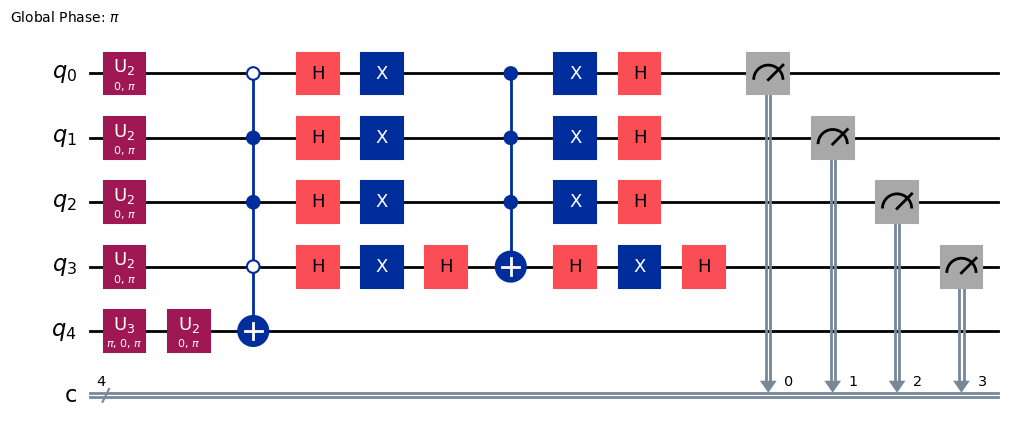

Circuit Comparison: 1 Shot Grover (ibm_rensselaer) vs Optimal Grover (ibm_rensselaer)
Metric..............       Circuit 1       Circuit 2     Winner
------------------------------------------------------------
Depth...............             349            1004 1 Shot Grover (ibm_rensselaer)
Size (gates)........             583            1592 1 Shot Grover (ibm_rensselaer)
Two-qubit gates.....              93             276 1 Shot Grover (ibm_rensselaer)
Exec time (μs)......            36.6           111.9 1 Shot Grover (ibm_rensselaer)
Gate error..........         100.0%         100.0%          -
Decoherence error...          56.1%          91.9%          -
Total error est.....         156.1%         191.9% 1 Shot Grover (ibm_rensselaer)

Key Insights:
  • Depth ratio: 2.9x (deeper circuit may perform better)
  • Significant error difference: 35.8%
  ⚠️  High decoherence error detected (>10%) - consider shorter circuits


{'circuits': {'1 Shot Grover (ibm_rensselaer)': {'depth': 349,
   'size': 583,
   'two_qubit_gates': 93,
   'exec_time_us': 36.636020583190394,
   'gate_error': 1.0,
   'decoherence_error': np.float64(0.5614627241406244)},
  'Optimal Grover (ibm_rensselaer)': {'depth': 1004,
   'size': 1592,
   'two_qubit_gates': 276,
   'exec_time_us': 111.9283417085427,
   'gate_error': 1.0,
   'decoherence_error': np.float64(0.9194105626610153)}},
 'winner': {'depth': '1 Shot Grover (ibm_rensselaer)',
  'size': '1 Shot Grover (ibm_rensselaer)',
  'two_qubit': '1 Shot Grover (ibm_rensselaer)',
  'exec_time': '1 Shot Grover (ibm_rensselaer)',
  'total_error': '1 Shot Grover (ibm_rensselaer)'}}

In [42]:
import qiskit
from qiskit.circuit.library import grover_operator
from qiskit_aer import AerSimulator

def build_grover_circuit(oracle: qiskit.QuantumCircuit, num_vars: int, grover_iterations: int) -> qiskit.QuantumCircuit:
        # Build Grover operator
        grover_op = grover_operator(oracle, reflection_qubits=range(num_vars))

        # Create search circuit
        search_circuit = qiskit.QuantumCircuit(oracle.num_qubits, num_vars)

        # Initialize ancilla for Uf mode
        search_circuit.x(num_vars)
        search_circuit.h(num_vars)

        # Initialize superposition
        search_circuit.h(range(num_vars))

        # Apply Grover operator
        if grover_iterations > 0:
            search_circuit.compose(grover_op.power(grover_iterations), inplace=True)

        # Measure
        search_circuit.measure(range(num_vars), range(num_vars))

        return search_circuit

grover = build_grover_circuit(oracle, n, 1)
grover_opt = build_grover_circuit(oracle, n, 3)


grover = grover.decompose()
display(grover.draw('mpl'))

rpi_grover = qiskit.transpile(grover, backend=backend)
rpi_grover_opt = qiskit.transpile(grover_opt, backend=backend)
compare_circuits(rpi_grover, rpi_grover_opt, ("1 Shot Grover (ibm_rensselaer)", "Optimal Grover (ibm_rensselaer)"))

In [27]:
from typing import Optional, Dict
from qiskit import QuantumCircuit

def run_simulation(circuit: qiskit.QuantumCircuit) -> Optional[Dict[str, int]]:
    simulator = AerSimulator()
    
    try:
        # Transpile for simulator
        qc = qiskit.transpile(
            circuit,
            simulator,
            optimization_level=3,
        )

        # Run simulation
        result = simulator.run(qc, shots=10**4).result()
        counts = result.get_counts()

        print(f"Simulation completed: {len(counts)} unique outcomes")
        return counts

    except Exception as e:
        print(f"Simulation failed: {e}")
        return None

def run_on_qc(circuit: QuantumCircuit) -> Optional[Dict[str, int]]:
    from qiskit_ibm_runtime import Sampler
    sampler = Sampler(backend)
    qc = qiskit.transpile(circuit, backend=backend, optimization_level=3)
    job = sampler.run([qc], shots=10**4)
    print(job.job_id())
    return job

sim_counts = run_simulation(circuit=grover)
#job = run_on_qc(circuit=grover)
#result = job.result()
#hw_counts = result[0].data.c.get_counts()

Simulation completed: 16 unique outcomes


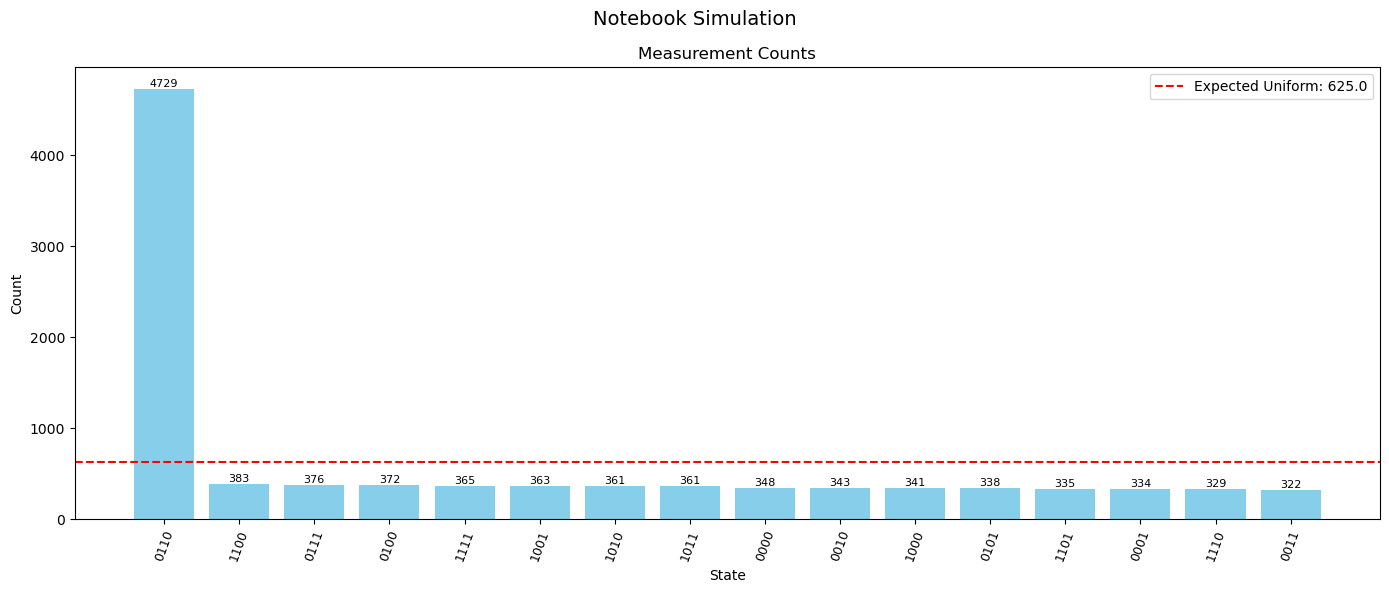

Total samples: 10000
Highest state: 0110 (4729 counts, 47.29%)
Lowest state: 0011 (322 counts, 3.22%)
✓ Strong signal detected in state 0110 (47.3%)


{'total_samples': 10000, 'top_state': '0110', 'top_probability': 0.4729}

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def simple_visualize_results(results_dict, title="Quantum Measurement Results"):
    # Basic calculations
    total_samples = sum(results_dict.values())
    n_qubits = len(list(results_dict.keys())[0])
    
    # Sort results by count (descending)
    sorted_results = dict(sorted(results_dict.items(), key=lambda x: x[1], reverse=True))
    
    # Create figure with two subplots
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # 1. Bar chart of states
    bars = ax1.bar(range(len(sorted_results)), sorted_results.values(), color='skyblue')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontsize=8)
    
    # Set the x-tick positions and labels
    ax1.set_xticks(range(len(sorted_results)))
    ax1.set_xticklabels(list(sorted_results.keys()), rotation=70, fontsize=9)
    
    # Add uniform expectation line
    expected_uniform = total_samples / len(results_dict)
    ax1.axhline(y=expected_uniform, color='red', linestyle='--', 
                label=f'Expected Uniform: {expected_uniform:.1f}')
    
    ax1.set_title('Measurement Counts')
    ax1.set_xlabel('State')
    ax1.set_ylabel('Count')
    ax1.legend()
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print simple statistics
    print(f"Total samples: {total_samples}")
    print(f"Highest state: {list(sorted_results.keys())[0]} ({list(sorted_results.values())[0]} counts, {list(sorted_results.values())[0]/total_samples*100:.2f}%)")
    print(f"Lowest state: {list(sorted_results.keys())[-1]} ({list(sorted_results.values())[-1]} counts, {list(sorted_results.values())[-1]/total_samples*100:.2f}%)")
    
    # Check for clear winner (probability > 20%)
    top_prob = list(sorted_results.values())[0] / total_samples
    if top_prob > 0.2:
        print(f"✓ Strong signal detected in state {list(sorted_results.keys())[0]} ({top_prob*100:.1f}%)")
    else:
        print(f"⚠ No clear winner detected. Top state has only {top_prob*100:.1f}% probability")
    
    # Check for uniformity
    uniformity_threshold = 0.05  # 5% variation
    max_variation = max(abs(count/total_samples - 1/len(results_dict)) for count in results_dict.values())
    
    if max_variation < uniformity_threshold:
        print(f"⚠ Distribution appears close to uniform (max variation: {max_variation*100:.1f}%)")
    
    # Return a simple summary for programmatic use
    return {
        "total_samples": total_samples,
        "top_state": list(sorted_results.keys())[0],
        "top_probability": top_prob,
    }

# from this notebook
display(simple_visualize_results(sim_counts, "Notebook Simulation"))
#display(simple_visualize_results(hw_counts, "Notebook HW Results"))